In [4]:
import ee
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
import pprint
import branca.colormap as cm

In [34]:
i_date = "2012-01-01"
f_date = "2022-01-01"

#area of interest
lon = -45.685694
lat = -23.100421
poi = ee.Geometry.Point(lon, lat)

scale = 1000

## Soil texture to hydraulic properties
dsfdsfgdsgs

In [2]:
olm_depths = [0, 10, 30, 60, 100, 200]
olm_bands = ["b" + str(sd) for sd in olm_depths]
olm_bands

['b0', 'b10', 'b30', 'b60', 'b100', 'b200']

In [5]:
#sand image
snippet = "OpenLandMap/SOL/SOL_SAND-WFRACTION_USDA-3A1A1A_M/v02"
scale_factor = 0.01
sand = ee.Image(snippet).multiply(scale_factor)

In [6]:
#clay image
snippet = "OpenLandMap/SOL/SOL_CLAY-WFRACTION_USDA-3A1A1A_M/v02"
scale_factor = 0.01
clay = ee.Image(snippet).multiply(scale_factor)

In [7]:
#organic carbon image
snippet = "OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02"
scale_factor = 5 * 0.001 #to get kg/kg
orgc = ee.Image(snippet).multiply(scale_factor)

In [11]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict["tile_fetcher"].url_format,
        attr="Map Data &copy; <a href='https://earthengine.google.com/'>Google Earth Engine</a>",
        name=name,
        overlay=True,
        control=True,
    ).add_to(self)


# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

my_map = folium.Map(location=[lat, lon], zoom_start=8)

# Set visualization parameters.
vis_params = {
    "bands": ["b0"],
    "min": 0.01,
    "max": 1,
    "opacity": 1,
    "palette": ["white", "#464646"],
}

# Add the sand content data to the map object.
my_map.add_ee_layer(sand, vis_params, "Sand Content")

# Add a marker at the location of interest.
folium.Marker([lat, lon], popup="point of interest").add_to(my_map)

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

Getting soil properties profiles in the region of interest.
example below is to obtain the sand profile

In [13]:
sand_prop = sand.sample(poi, scale).select(olm_bands).getInfo()
sand_prop

{'type': 'FeatureCollection',
 'columns': {},
 'properties': {'band_order': ['b0', 'b10', 'b30', 'b60', 'b100', 'b200']},
 'features': [{'type': 'Feature',
   'geometry': None,
   'id': '0',
   'properties': {'b0': 0.44,
    'b10': 0.44,
    'b100': 0.41000000000000003,
    'b200': 0.43,
    'b30': 0.41000000000000003,
    'b60': 0.41000000000000003}}]}

In [17]:
profile_sand = sand_prop["features"][0]["properties"]
profile_sand = {key: round(val, 3) for key, val in profile_sand.items()}
profile_sand

{'b0': 0.44, 'b10': 0.44, 'b100': 0.41, 'b200': 0.43, 'b30': 0.41, 'b60': 0.41}

Doing the same to get clay and organic matter profiles

Note that the organic carbon need to be converted to organic matter to be used in equation of Saxton and Rawls [2006]. It can be did by using the equation:

$ OM = 1.724 OC $

where $ OM $ is organic matter and $ OC $ is the organic carbon

In [30]:
clay_prop = clay.sample(poi, scale).select(olm_bands).getInfo()
profile_clay = clay_prop["features"][0]["properties"]
profile_clay = {key: round(val, 3) for key, val in profile_clay.items()}

orgc_prop = orgc.sample(poi, scale).select(olm_bands).getInfo()
profile_orgc = orgc_prop["features"][0]["properties"]
profile_orgm = {key: round(val * 1.724, 3) for key, val in profile_orgc.items()}
orgm = orgc.multiply(1.724)

Vizualizing the soil properties profile of the area of interest

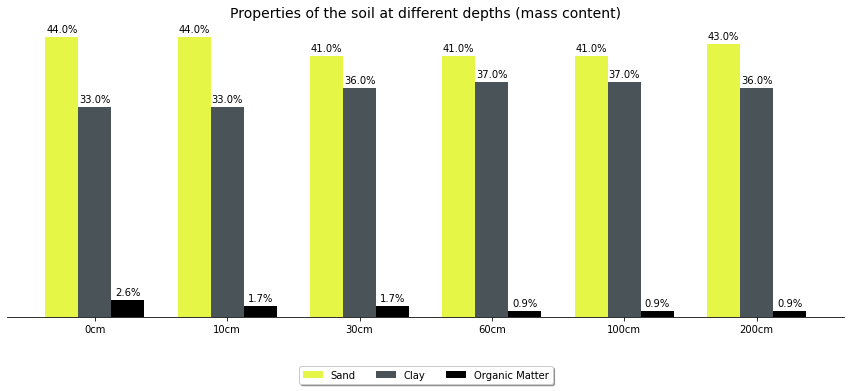

In [29]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.axes.get_yaxis().set_visible(False)

x = np.arange(len(olm_bands))

width = 0.25

#bar sand
rect1 = ax.bar(x - width, 
    [round(100 * profile_sand[b], 2) for b in olm_bands],
    width=width, 
    label="Sand", 
    color="#e6f647")
#bar clay
rect2 = ax.bar(x, 
    [round(100 * profile_clay[b], 2) for b in olm_bands],
    width=width, 
    label="Clay",
    color="#495358")
#bar organic matter
rect3 = ax.bar(x + width,
    [round(100 * profile_orgm[b], 2) for b in olm_bands], 
    width=width, 
    label="Organic Matter", 
    color="000000", 
    #alpha=0.75, 
    )

def autolabel_soil_prop(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate("{}".format(height) + "%", 
            xy=(rect.get_x() + rect.get_width() / 2, height), 
            xytext=(0, 3), 
            textcoords="offset points", 
            ha="center", 
            va="bottom", 
            fontsize=10)
autolabel_soil_prop(rect1)
autolabel_soil_prop(rect2)
autolabel_soil_prop(rect3)

ax.set_title("Properties of the soil at different depths (mass content)", fontsize=14)

ax.set_xticks(x)
x_labels = [str(d) + "cm" for d in olm_depths]
ax.set_xticklabels(x_labels, fontsize=10)

ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

ax.legend(loc="upper center", 
    bbox_to_anchor=(0.5, -0.15), 
    fancybox=True,
    shadow=True, 
    ncol = 3)

plt.show()

## Calculating the wilting point and field capacity

Applying the mathematical expression

In [33]:
wilting_point = ee.Image(0)
field_capacity = ee.Image(0)

for key in olm_bands:
    si = sand.select(key)
    ci = clay.select(key)
    oi = orgm.select(key)

    #calculate wilting point at band i
    theta_1500ti = (
        ee.Image(0).expression(
            "-0.024 * S + 0.487 * C + 0.006 * OM + 0.005 * (S * OM) - 0.013 * (C * OM) + 0.068 * (S * C) + 0.031", 
            {"S": si, "C": ci, "OM": oi}
        ).rename("T1500ti")
    )

    wpi = theta_1500ti.expression(
        "T1500ti + (0.14 * T1500ti - 0.002)", 
        {"T1500ti": theta_1500ti}
    ).rename("wpi")

    wilting_point = wilting_point.addBands(wpi.rename(key).float())

    #calculate field capacity at band i
    theta_33ti = (
        ee.Image(0).expression(
            "-0.251 * S + 0.195 * C + 0.011 * OM + 0.006 * (S * OM) - 0.027 * (C * OM) + 0.452 * (S * C) + 0.299", 
            {"S": si, "C": ci, "OM": oi}
        ).rename("T33ti")
    )

    fci = theta_33ti.expression(
        "T33ti + (1.283 * T33ti * T33ti - 0.374 * T33ti - 0.015", 
        {"T33ti": theta_33ti.select("T33ti")}
    )

    field_capacity = field_capacity.addBands(fci.rename(key).float())

In [ ]:
#fazer o bar plot com o wilting point e field capacity igual 
#fez com o sand, clay e om

## Meteorological Data

* [CHIRPS Daily: Climate Hazards Group InfraRed Precipitation With Station Data (Version 2.0 Final)](https://developers.google.com/earth-engine/datasets/catalog/UCSB-CHG_CHIRPS_DAILY)
* [MOD16A2.006: Terra Net Evapotranspiration 8-Day Global 500m](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD16A2)

In [35]:
#getting precipitation data
pr = (
    ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")
    .select("precipitation").filterDate(i_date, f_date)
)

#getting potential evaporation data and its quality indicator
pet = (
    ee.ImageCollection("MODIS/006/MOD16A2")
    .select(["PET", "ET_QC"]).filterDate(i_date, f_date)
)

precipitation

In [38]:
local_pr = pr.getRegion(poi, scale).getInfo()
pprint.pprint(local_pr[:5])

[['id', 'longitude', 'latitude', 'time', 'precipitation'],
 ['20120101',
  -45.68382377389827,
  -23.100177531133497,
  1325376000000,
  33.581546783447266],
 ['20120102', -45.68382377389827, -23.100177531133497, 1325462400000, 0],
 ['20120103', -45.68382377389827, -23.100177531133497, 1325548800000, 0],
 ['20120104', -45.68382377389827, -23.100177531133497, 1325635200000, 0]]


In [39]:
#df precipitation
pr_df = pd.DataFrame(local_pr)
headers = pr_df.iloc[0]
pr_df = pd.DataFrame(pr_df.values[1:], columns=headers)

#pr data to numeric
pr_df["precipitation"] = pd.to_numeric(pr_df["precipitation"], errors="coerce")

#time field to datetime
pr_df["datetime"] = pd.to_datetime(pr_df["time"], unit="ms")

#cleaning
pr_df = pr_df[["time", "datetime", "precipitation"]]
pr_df = pr_df.set_index("datetime")

#vizualizing
pr_df.head()

,time,precipitation
datetime,,
2012-01-01,1325376000000,33.581547
2012-01-02,1325462400000,0.000000
2012-01-03,1325548800000,0.000000
2012-01-04,1325635200000,0.000000
2012-01-05,1325721600000,5.596924


doing the same for potential evaporation. Note the data is not daily as precipitation. It is 8 day average as described in the metadata.

In [40]:
#potential evaporation data
local_pet = pet.getRegion(poi, scale).getInfo()
pet_df = pd.DataFrame(local_pet)
headers = pet_df.iloc[0]
pet_df = pd.DataFrame(pet_df.values[1:], columns=headers)

#pet data to numeric
for band in ["PET", "ET_QC"]:
    pet_df[band] = pd.to_numeric(pet_df[band], errors="coerce")

#time to datetime
pet_df["datetime"] = pd.to_datetime(pet_df["time"], unit="ms")

#cleaning
pet_df = pet_df[["time", "datetime", "PET", "ET_QC"]]
pet_df = pet_df.set_index("datetime")

#vizualizing
pet_df.head()

,time,PET,ET_QC
datetime,,,
2012-01-01,1325376000000,504.0,157
2012-01-09,1326067200000,NaN,157
2012-01-17,1326758400000,NaN,157
2012-01-25,1327449600000,461.0,157
2012-02-02,1328140800000,649.0,157


Because the two datasets do not have the same timeline is necessary to resampling the time resolution to get a homogeneous time index and missing values. It will be achieved by resampling both datasets by month.

In [41]:
#this function is a code of Guillaume Attard. 
#Source: https://gist.github.com/guiattard/dc11243474d20c973d31cecb23524831#file-pfg6-meteo-6-py

def sum_resampler(coll, freq, unit, scale_factor, band_name):
    """
    This function aims to resample the time scale of an ee.ImageCollection.
    The function returns an ee.ImageCollection with the averaged sum of the
    band on the selected frequency.
    coll: (ee.ImageCollection) only one band can be handled
    freq: (int) corresponds to the resampling frequence
    unit: (str) corresponds to the resampling time unit.
                must be 'day', 'month' or 'year'
    scale_factor (float): scaling factor used to get our value in the good unit
    band_name (str) name of the output band
    """

    # Define initial and final dates of the collection.
    firstdate = ee.Date(
        coll.sort("system:time_start", True).first().get("system:time_start")
    )

    lastdate = ee.Date(
        coll.sort("system:time_start", False).first().get("system:time_start")
    )

    # Calculate the time difference between both dates.
    # https://developers.google.com/earth-engine/apidocs/ee-date-difference
    diff_dates = lastdate.difference(firstdate, unit)

    # Define a new time index (for output).
    new_index = ee.List.sequence(0, ee.Number(diff_dates), freq)

    # Define the function that will be applied to our new time index.
    def apply_resampling(date_index):
        # Define the starting date to take into account.
        startdate = firstdate.advance(ee.Number(date_index), unit)

        # Define the ending date to take into account according
        # to the desired frequency.
        enddate = firstdate.advance(ee.Number(date_index).add(freq), unit)

        # Calculate the number of days between starting and ending days.
        diff_days = enddate.difference(startdate, "day")

        # Calculate the composite image.
        image = (
            coll.filterDate(startdate, enddate)
            .mean()
            .multiply(diff_days)
            .multiply(scale_factor)
            .rename(band_name)
        )

        # Return the final image with the appropriate time index.
        return image.set("system:time_start", startdate.millis())

    # Map the function to the new time index.
    res = new_index.map(apply_resampling)

    # Transform the result into an ee.ImageCollection.
    res = ee.ImageCollection(res)

    return res

For evapotranspiration dataset gives us an 8-day sum and a scale factor of 10 is applied. We need to rescale by dividing by 8 and 10:

In [42]:
#resampling precipitation
pr_m = sum_resampler(pr, 1, "month", 1, "pr")

#resampling PET
pet_m = sum_resampler(pet.select("PET"), 1, "month", 0.0125, "pet")

Combining precipitation and PET datasets and vizualizing for the area of interest.

In [44]:
meteo = pr_m.combine(pet_m)
meteo_arr = meteo.getRegion(poi, scale).getInfo()

#meteo dataframe
meteo_df = pd.DataFrame(meteo_arr)
headers = meteo_df.iloc[0]
meteo_df = pd.DataFrame(meteo_df.values[1:], columns=headers)

#meteo data to numeric
for band in ["pr", "pet"]:
    meteo_df[band] = pd.to_numeric(meteo_df[band], errors="coerce")

#time field to datetime
meteo_df["datetime"] = pd.to_datetime(meteo_df["time"], unit="ms")

#cleaning
meteo_df = meteo_df[["time", "datetime", "pr", "pet"]]
meteo_df = meteo_df.set_index("datetime")
meteo_df = meteo_df.sort_index()

#vizualizing
meteo_df.head()

,time,pr,pet
datetime,,,
2012-01-01,1325376000000,276.223151,186.968750
2012-02-01,1328054400000,131.258315,197.804167
2012-03-01,1330560000000,113.144179,170.112500
2012-04-01,1333238400000,104.058466,126.375000
2012-05-01,1335830400000,61.901220,101.525000


Note that the above table has the monthly pr and pet data for the area of interest.

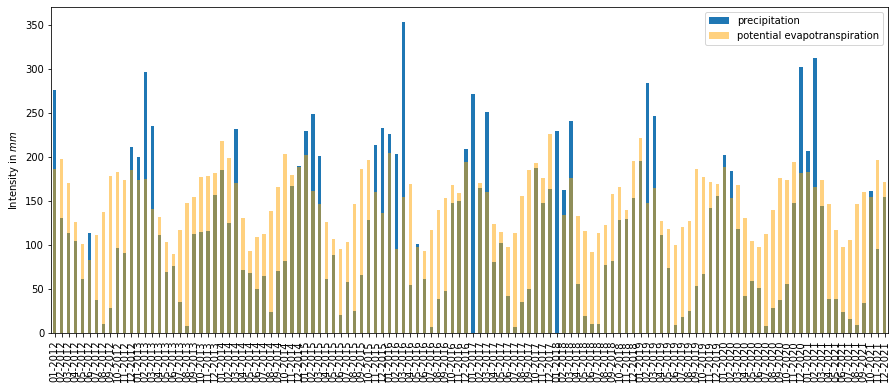

In [48]:
#data vizualization
fig, ax = plt.subplots(figsize=(15, 6))
meteo_df["pr"].plot(kind="bar", ax=ax, label="precipitation")
meteo_df["pet"].plot(kind="bar", ax=ax, label="potential evapotranspiration",
    color="orange",
    alpha=0.5, 
    )

ax.legend()
ax.set_ylabel("Intensity in $ mm $")
ax.set_xlabel(None)

x_labels = meteo_df.index.strftime("%m-%Y")
ax.set_xticklabels(x_labels, rotation=90, fontsize=10)

plt.show()

## TM Procedure

## References

## Data
Funk, Chris, Pete Peterson, Martin Landsfeld, Diego Pedreros, James Verdin, Shraddhanand Shukla, Gregory Husak, James Rowland, Laura Harrison, Andrew Hoell & Joel Michaelsen. "The climate hazards infrared precipitation with stations—a new environmental record for monitoring extremes". Scientific Data 2, 150066. [doi:10.1038/sdata.2015.66](https://www.nature.com/articles/sdata201566) 2015.

Running, S., Mu, Q., Zhao, M. (2017). MOD16A2 MODIS/Terra Net Evapotranspiration 8-Day L4 Global 500m SIN Grid V006 [Data set]. NASA EOSDIS Land Processes DAAC. Accessed 2022-06-19 from [doi.org/10.5067/MODIS/MOD16A2.006](https://lpdaac.usgs.gov/products/mod16a2v006/)

Tomislav Hengl. (2018). Sand content in % (kg / kg) at 6 standard depths (0, 10, 30, 60, 100 and 200 cm) at 250 m resolution (Version v02) [Data set]. [doi.org/10.5281/zenodo.1476851](https://zenodo.org/record/2525662#.Yq-s3_3MKUk)

Tomislav Hengl. (2018). Clay content in % (kg / kg) at 6 standard depths (0, 10, 30, 60, 100 and 200 cm) at 250 m resolution (Version v02) [Data set]. [doi.org/10.5281/zenodo.1476854](https://zenodo.org/record/2525663#.Yq-tHv3MKUk)

Tomislav Hengl, & Ichsani Wheeler. (2018). Soil organic carbon content in x 5 g / kg at 6 standard depths (0, 10, 30, 60, 100 and 200 cm) at 250 m resolution (Version v02) [Data set]. Zenodo. [doi.org/10.5281/zenodo.1475457](https://zenodo.org/record/2525553#.Yq-tRP3MKUk)